In [158]:
import os
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import from_networkx
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split

In [159]:
torch.manual_seed(1234567)
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]


folder_path = 'client_subgraphs'
sub_data_list = []

for filename in os.listdir(folder_path):
    if filename.endswith('.gml'):
      
        file_path = os.path.join(folder_path, filename)
        g = nx.read_gml(file_path)

        subgraph_nodes = list(g.nodes)
        subgraph_nodes = [int(node) for node in subgraph_nodes]  # Convert to integer if they are not

        sub_edge_index, _ = subgraph(subgraph_nodes, data.edge_index, relabel_nodes=True)

        sub_data = Data(x=data.x[subgraph_nodes], edge_index=sub_edge_index, y=data.y[subgraph_nodes])
        sub_data_list.append(sub_data)


In [160]:
print(sub_data_list[0])
print(sub_data_list[0].x.shape)

Data(x=[18, 1433], edge_index=[2, 58], y=[18])
torch.Size([18, 1433])


In [5]:
# #plot subgraph 0 to make sure it looks right
# import matplotlib.pyplot as plt
# import networkx as nx
# from torch_geometric.utils import to_networkx

# G = to_networkx(sub_data_list[82], to_undirected=False)
# plt.figure(figsize=(20,20))
# nx.draw(G, with_labels=True, node_size=15, node_color='g', edge_color='b')
# plt.show()


In [161]:

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First convolutional layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        # Second convolutional layer
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [33]:
#keep a  list of training and validation loss per epoch for each subgraph
train_losses = []
val_losses = []

In [162]:
import torch



def transductive_split(data, train_percent=0.8, val_percent=0.1):
    """
    Split graph data into training, validation, and testing sets for transductive learning.
    :param data: PyG Data object
    :param train_percent: Percentage of nodes to be used for training
    :param val_percent: Percentage of nodes to be used for validation
    :return: data object with train_mask, val_mask, and test_mask attributes added
    """
    # set a seed for reproducibility

    num_nodes = data.num_nodes
    train_size = int(train_percent * num_nodes)
    val_size = int(val_percent * num_nodes)

    # Create a random permutation of node indices
    perm = torch.randperm(num_nodes)

    # Create masks for training, validation, and testing nodes
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[perm[:train_size]] = True
    val_mask[perm[train_size:train_size + val_size]] = True
    test_mask[perm[train_size + val_size:]] = True

    # Add masks to data object
    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask

    return data


In [163]:
# splitting the subgraphs into train test and val 
for i in range(0, 100):
    sub_data = sub_data_list[i]
    sub_data = transductive_split(sub_data)


print(torch.sum(sub_data_list[4].train_mask).item())  # Number of training nodes
print(torch.sum(sub_data_list[4].val_mask).item())    # Number of validation nodes
print(torch.sum(sub_data_list[4].test_mask).item()) 

10
1
2


In [164]:
from torch_geometric.nn import GCNConv
    
    
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training) # p = 0.25
        x = self.conv2(x, edge_index)
        return x
    


model = GCN(sub_data.num_node_features, dataset.num_classes).to(device)

final test loss:  0.00013207436131779104  for subgraph  0
final test accuracy:  1.0  for subgraph  0
------------------------------------------------------------
final test loss:  3.3207669258117676  for subgraph  1
final test accuracy:  0.5  for subgraph  1
------------------------------------------------------------
final test loss:  1.9536924362182617  for subgraph  2
final test accuracy:  0.3333333333333333  for subgraph  2
------------------------------------------------------------
final test loss:  0.03765980154275894  for subgraph  3
final test accuracy:  1.0  for subgraph  3
------------------------------------------------------------
final test loss:  1.9814280271530151  for subgraph  4
final test accuracy:  0.5  for subgraph  4
------------------------------------------------------------
final test loss:  1.8994357585906982  for subgraph  5
final test accuracy:  0.5  for subgraph  5
------------------------------------------------------------
final test loss:  3.33447265625 

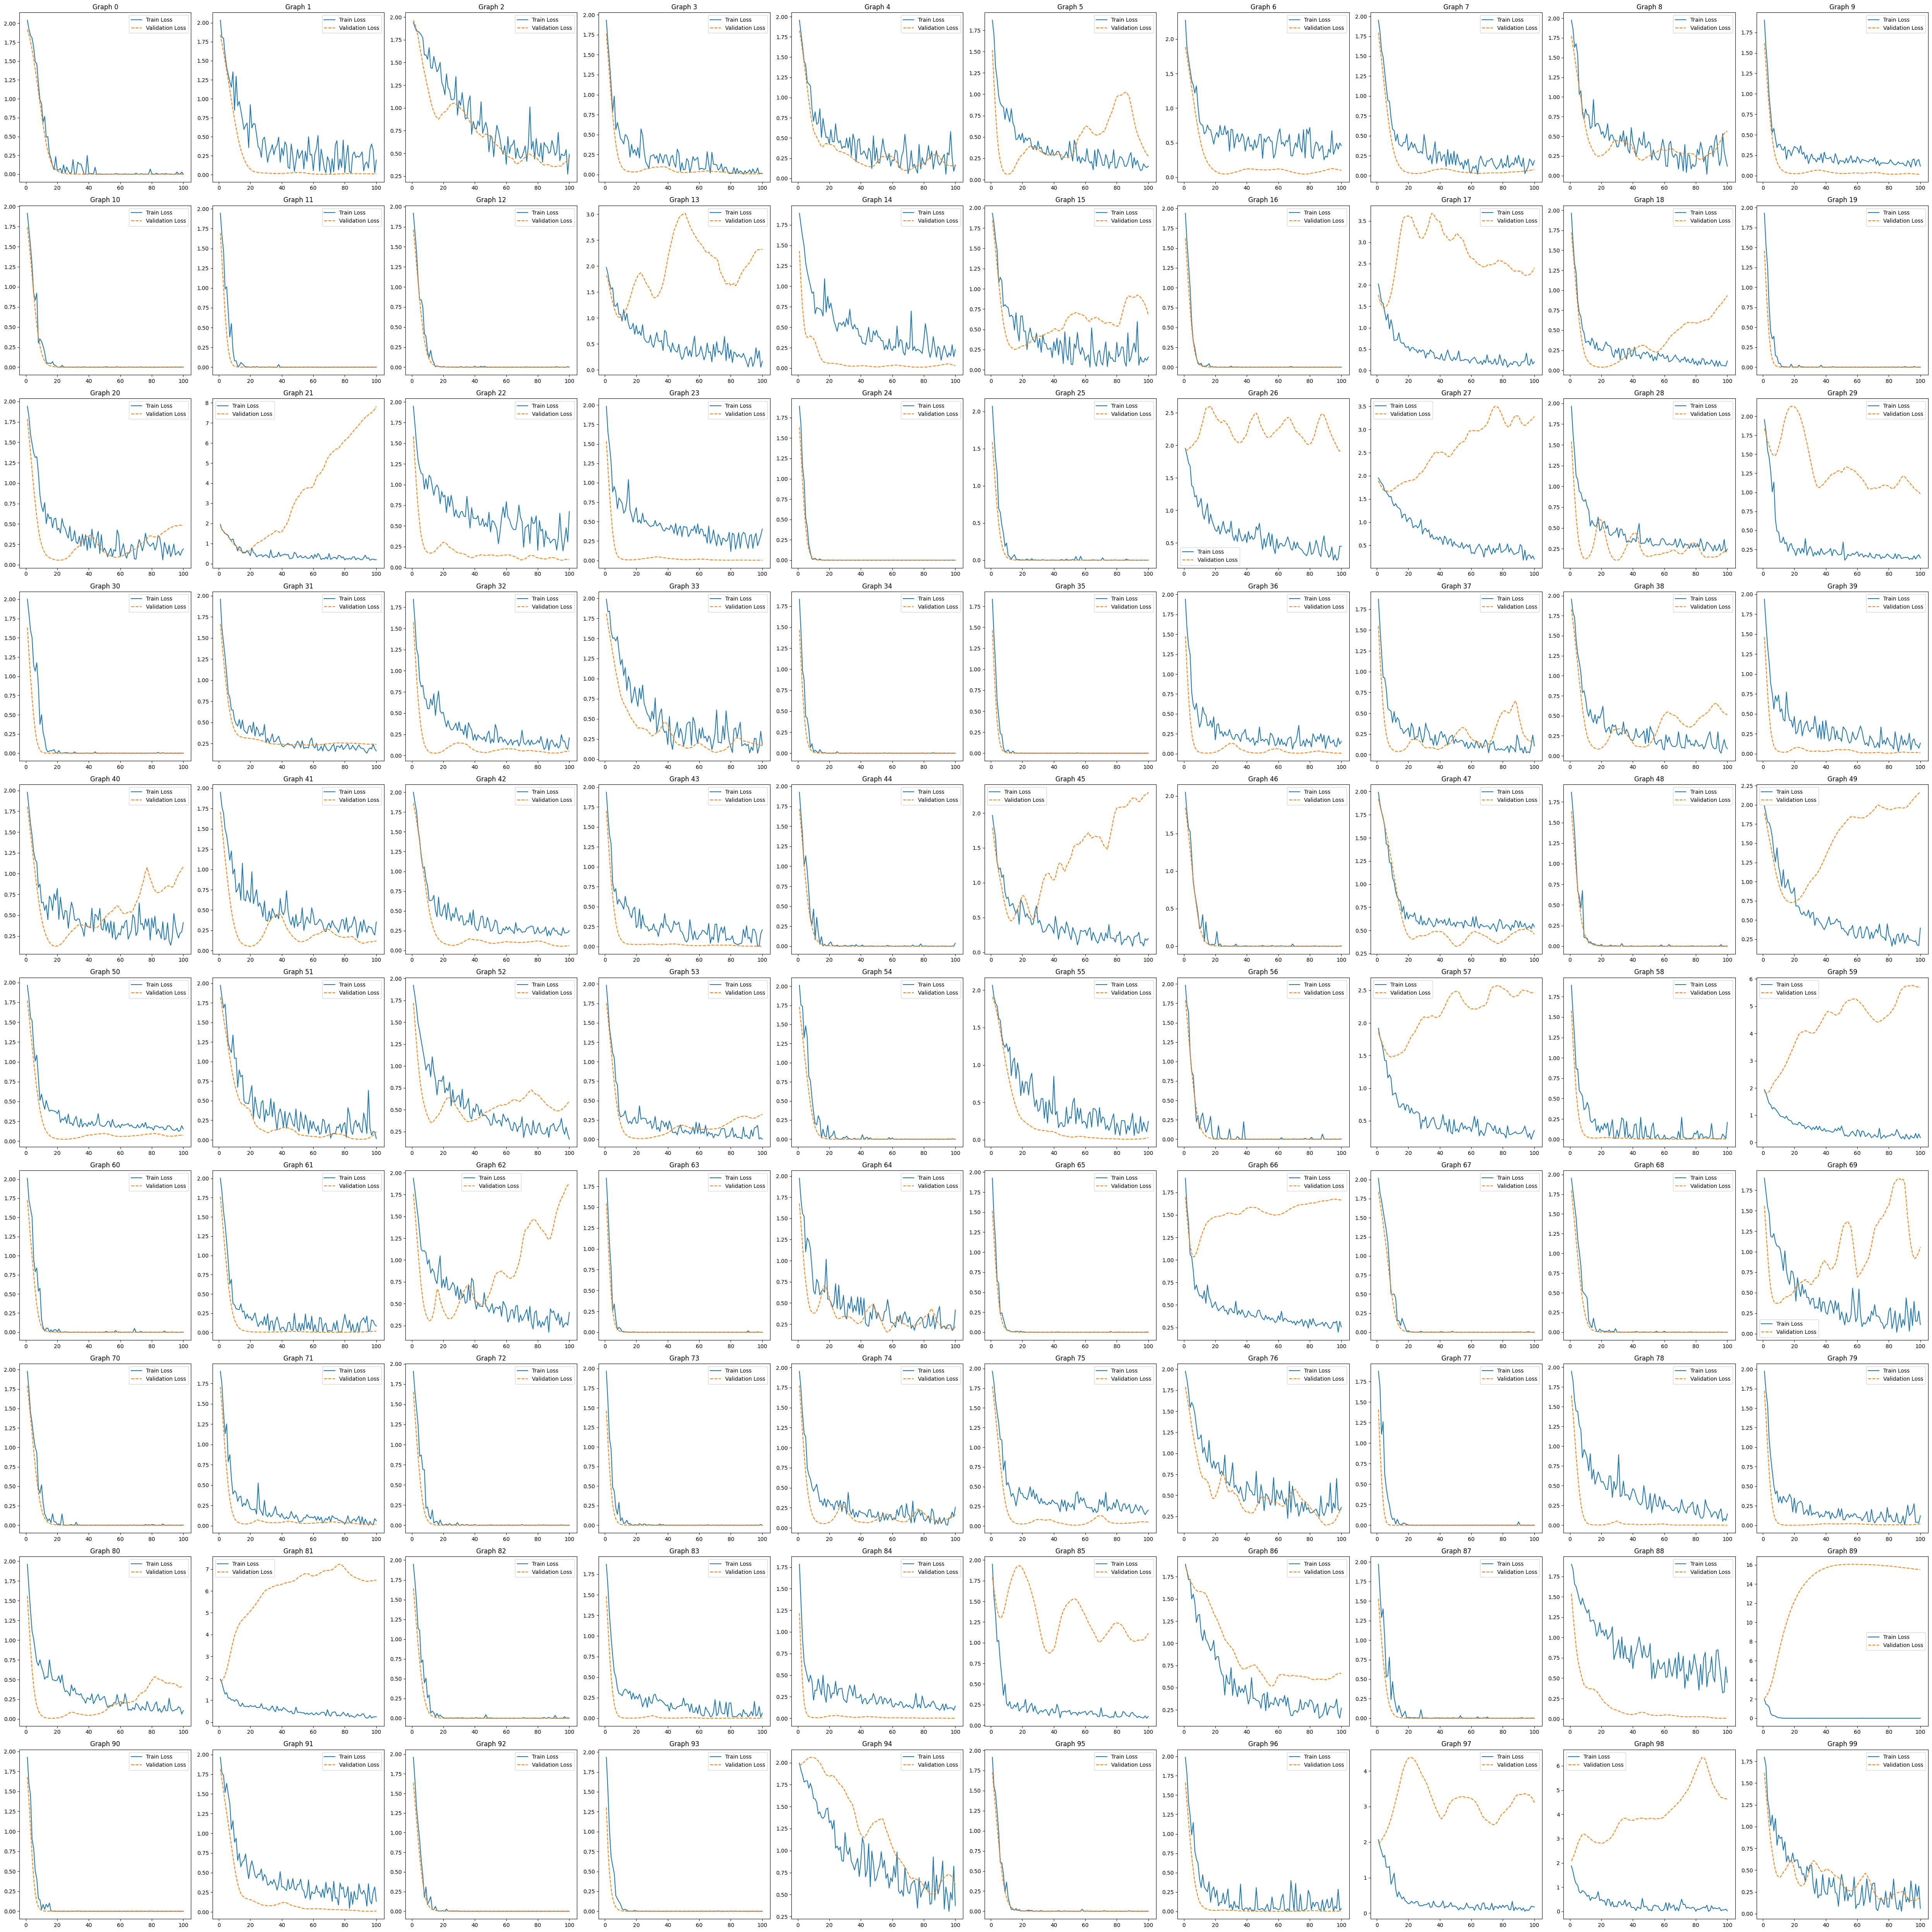

In [165]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 10, figsize=(50, 50))
test_losses = []
test_accs = []
def train(sub_data, model, optimizer, criterion):
      model.train()
      optimizer.zero_grad() 
      out = model(sub_data.x, sub_data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[sub_data.train_mask], sub_data.y[sub_data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward() 
      optimizer.step() 
      return loss

def test(sub_data, criterion, model):
      model.eval()
      out = model(sub_data.x, sub_data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[sub_data.test_mask] == sub_data.y[sub_data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(sub_data.test_mask.sum())  # Derive ratio of correct predictions.
      test_loss = criterion(out[sub_data.test_mask], sub_data.y[sub_data.test_mask])  # Compute validation loss
      
      return test_loss, test_acc


def validate(sub_data, model, criterion):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Do not compute gradients during this step
        out = model(sub_data.x, sub_data.edge_index)  # Forward pass
        pred = out.argmax(dim=1)  # Get predicted classes
        val_correct = pred[sub_data.val_mask] == sub_data.y[sub_data.val_mask]  # Compare with ground-truth
        val_loss = criterion(out[sub_data.val_mask], sub_data.y[sub_data.val_mask])  # Compute validation loss
        val_acc = int(val_correct.sum()) / int(sub_data.val_mask.sum())  # Compute validation accuracy
    return val_loss.item(), val_acc  # Return validation loss and accuracy


for i in range(len(sub_data_list)):
    sub_data = sub_data_list[i]
    
    model = GCN(sub_data.num_node_features, dataset.num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = [] 
    val_losses = []    

    # Training loop for each epoch (adjust the range as needed)
    for epoch in range(1, 101):
        train_loss = train(sub_data, model, optimizer, criterion)  # Assuming 'train' returns a loss
        val_loss, _ = validate(sub_data, model, criterion)         # Assuming 'validate' returns a loss and something else (like accuracy)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
    
    test_loss, test_acc = test(sub_data, criterion, model)
    #print test_loss and test_acc
    print("final test loss: ", test_loss.item(), " for subgraph ", i)
    print("final test accuracy: ", test_acc, " for subgraph ", i)
    print("------------------------------------------------------------")
    test_losses.append(test_loss.item())
    test_accs.append(test_acc)
    row = i // 10
    col = i % 10

    # Plotting on specific subplot
    axs[row, col].plot(range(1, 101), [loss.item() for loss in train_losses], label='Train Loss')
    axs[row, col].plot(range(1, 101), val_losses, label='Validation Loss', linestyle='dashed')
    axs[row, col].set_title(f'Graph {i}')
    axs[row, col].legend()
    
plt.tight_layout()
plt.show()



In [171]:
# see how many classes are in subgraph 23
print(sub_data_list[94].y.unique(return_counts=True))

print(sub_data_list[0].y.unique(return_counts=True))



(tensor([0, 1, 3, 4, 5, 6]), tensor([4, 1, 1, 2, 6, 6]))
(tensor([2]), tensor([18]))


In [ ]:
# plot the number of unique classes to the test accuracy
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 10, figsize=(50, 50))

